## Генерация изображений одной цифры при помощи сверточных генеративно-состязательных сетей

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

In [2]:
# Для упрощения сузим множество изображений только до семерок
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[y_train == 7]
y_train = y_train[y_train == 7]

In [3]:
# Сделаем величину выборки кратной батчу
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(x_train.shape, y_train.shape)

(6200, 28, 28) (6200,)


In [4]:
# Предобработка, перемешивание входных данных, формирование батчей
x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
# Задаем размерность латентного пространства
hidden_dim = 2


def dropout_and_batch():
    return Dropout(0.3)(BatchNormalization())

#### Модель генератора

`Conv2DTranspose` - сверточный слой, у которого входные карты признаков разреживаются, т.е. разделяются нулями. 

Интервал разреживания задается параметром `strides`.

Это позволяет увеличивать размерность выхода без использования `UpSampling2D`.

Подробно: https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d

In [6]:
generator = tf.keras.Sequential([
  Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim,)),
  BatchNormalization(),
  Reshape((7, 7, 256)),
  Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'),
])

#### Модель дискриминатора

In [7]:
# Модель дискриминатора
discriminator = tf.keras.Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))

In [8]:
# Составляем функции потерь
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(fake_output):
#     Для генератора желаемый выход - 1 (обмануть дискриминатор)
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


def discriminator_loss(real_output, fake_output):
#     Для дискриминатора желаемый выход - 0 для фейков, 1 для оригиналов
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [10]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])
    # GradientTape следит за изменениями обучаемых параметров и сохраняет метод вычисления их градиентов
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    # Вычисляем градиенты и поочередно применяем шаг оптимизации для генератора и дискриминатора
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [11]:
# Главный цикл обучения
def train(dataset, epochs):
    history = []
    history_disc = []
    MAX_PRINT_LABEL = 10
    th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)

    for epoch in range(1, epochs + 1):
        print(f'{epoch}/{EPOCHS}: ', end='')

        start = time.time()
        n = 0

        gen_loss_epoch = 0
        disc_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            disc_loss_epoch += K.mean(disc_loss)
            if (n % th == 0): print('=', end='')
            n += 1

        history += [gen_loss_epoch / n]
        history_disc += [disc_loss_epoch / n]
        print(': ' + str(history[-1]))
        print('Время эпохи {} составляет {} секунд'.format(epoch, time.time() - start))

    return history, history_disc

In [12]:
# запуск процесса обучения
EPOCHS = 20
history, history_disc = train(train_dataset, EPOCHS)

1/20: ===========: tf.Tensor(1.3899465, shape=(), dtype=float32)
Время эпохи 1 составляет 11.96838641166687 секунд
2/20: ===========: tf.Tensor(2.534957, shape=(), dtype=float32)
Время эпохи 2 составляет 11.235352039337158 секунд
3/20: ===========: tf.Tensor(3.1951468, shape=(), dtype=float32)
Время эпохи 3 составляет 11.226158142089844 секунд
4/20: ===========: tf.Tensor(3.2673762, shape=(), dtype=float32)
Время эпохи 4 составляет 11.450751066207886 секунд
5/20: ===========: tf.Tensor(3.5249462, shape=(), dtype=float32)
Время эпохи 5 составляет 11.587778091430664 секунд
6/20: ===========: tf.Tensor(3.1291316, shape=(), dtype=float32)
Время эпохи 6 составляет 11.620418310165405 секунд
7/20: ===========: tf.Tensor(3.0185528, shape=(), dtype=float32)
Время эпохи 7 составляет 11.628685712814331 секунд
8/20: ===========: tf.Tensor(3.2856479, shape=(), dtype=float32)
Время эпохи 8 составляет 11.676638841629028 секунд
9/20: ===========: tf.Tensor(3.336616, shape=(), dtype=float32)
Время эпох

Построим график усредненных потерь генератора по каждой эпохе. Видно типичное для GAN поведение функции потерь: сначала большие всплески, затем стабилизация.

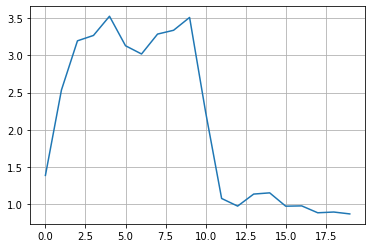

In [13]:
plt.plot(history)
plt.grid(True)
plt.show()

Построим график потерь дискриминатора. Он не сходится к нулю, поскольку генератор его "победил".

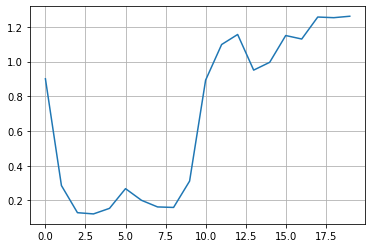

In [15]:
plt.plot(history_disc)
plt.grid(True)
plt.show()

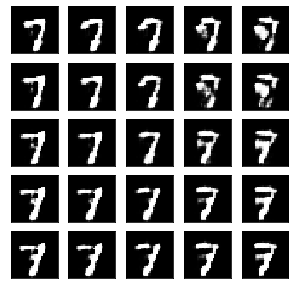

In [14]:
# Выведем несколько результатов генерации
n = 2
total = 2 * n + 1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n + 1):
  for j in range(-n, n + 1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
    plt.imshow(img[0, :, :, 0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

https://github.com/selfedu-rus/neural-network/blob/master/lesson%2032.%20GAN.py